# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


In [3]:
# Preview the dataset
df.head()


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [4]:
# Dataset information: data types and null counts
df.info()

# Unique value count per column
df.nunique().sort_values(ascending=False)

# Percent of missing values per column
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
missing_percent[missing_percent > 0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

buildingclasstypeid             99.980673
finishedsquarefeet13            99.945885
basementsqft                    99.935578
storytypeid                     99.935578
yardbuildingsqft26              99.909809
fireplaceflag                   99.778388
architecturalstyletypeid        99.733292
typeconstructiontypeid          99.712677
finishedsquarefeet6             99.502661
pooltypeid10                    99.400874
decktypeid                      99.208895
poolsizesum                     98.880342
pooltypeid2                     98.616211
hashottuborspa                  98.017085
yardbuildingsqft17              96.916754
taxdelinquencyyear              96.263513
taxdelinquencyflag              96.263513
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedfloor1squarefeet        92.221664
fireplacecnt                    89.320088
threequarterbathnbr             86.978985
pooltypeid7                     80.571554
poolcnt                         79

In [5]:
# Summary statistics for numerical columns
# Summarizes central tendency, spread, and outliers in numeric features. 
# Sorting by standard deviation highlights the most variable features.

df.describe().T.sort_values(by='std', ascending=False).round(2)

,count,mean,std,min,25%,50%,75%,max
censustractandblock,77332.0,6.049667e+13,1.533339e+12,6.037101e+13,6.037311e+13,6.037603e+13,6.059042e+13,4.830301e+14
parcelid,77613.0,1.300781e+07,3.518717e+06,1.071186e+07,1.153821e+07,1.253004e+07,1.421101e+07,1.676893e+08
taxvaluedollarcnt,77578.0,4.901506e+05,6.537979e+05,1.000000e+03,2.068985e+05,3.588785e+05,5.690000e+05,4.906124e+07
longitude,77579.0,-1.182037e+08,3.594085e+05,-1.194754e+08,-1.184150e+08,-1.181810e+08,-1.179286e+08,-1.175546e+08
latitude,77579.0,3.400837e+07,2.652873e+05,3.333953e+07,3.381463e+07,3.402200e+07,3.417431e+07,3.481877e+07
rawcensustractandblock,77579.0,6.049124e+07,2.058962e+05,6.037101e+07,6.037311e+07,6.037603e+07,6.059042e+07,6.111009e+07
regionidneighborhood,30974.0,1.877251e+05,1.650451e+05,6.952000e+03,4.673600e+04,1.188490e+05,2.747650e+05,7.641670e+05
lotsizesquarefeet,69321.0,2.997344e+04,1.233051e+05,2.360000e+02,5.700000e+03,7.206000e+03,1.183700e+04,6.971010e+06
regionidcity,76107.0,3.368306e+04,4.721178e+04,3.491000e+03,1.244700e+04,2.521800e+04,4.545700e+04,3.965560e+05
regionidzip,77529.0,9.658669e+04,3.793550e+03,9.598200e+04,9.619300e+04,9.638900e+04,9.698700e+04,3.996750e+05


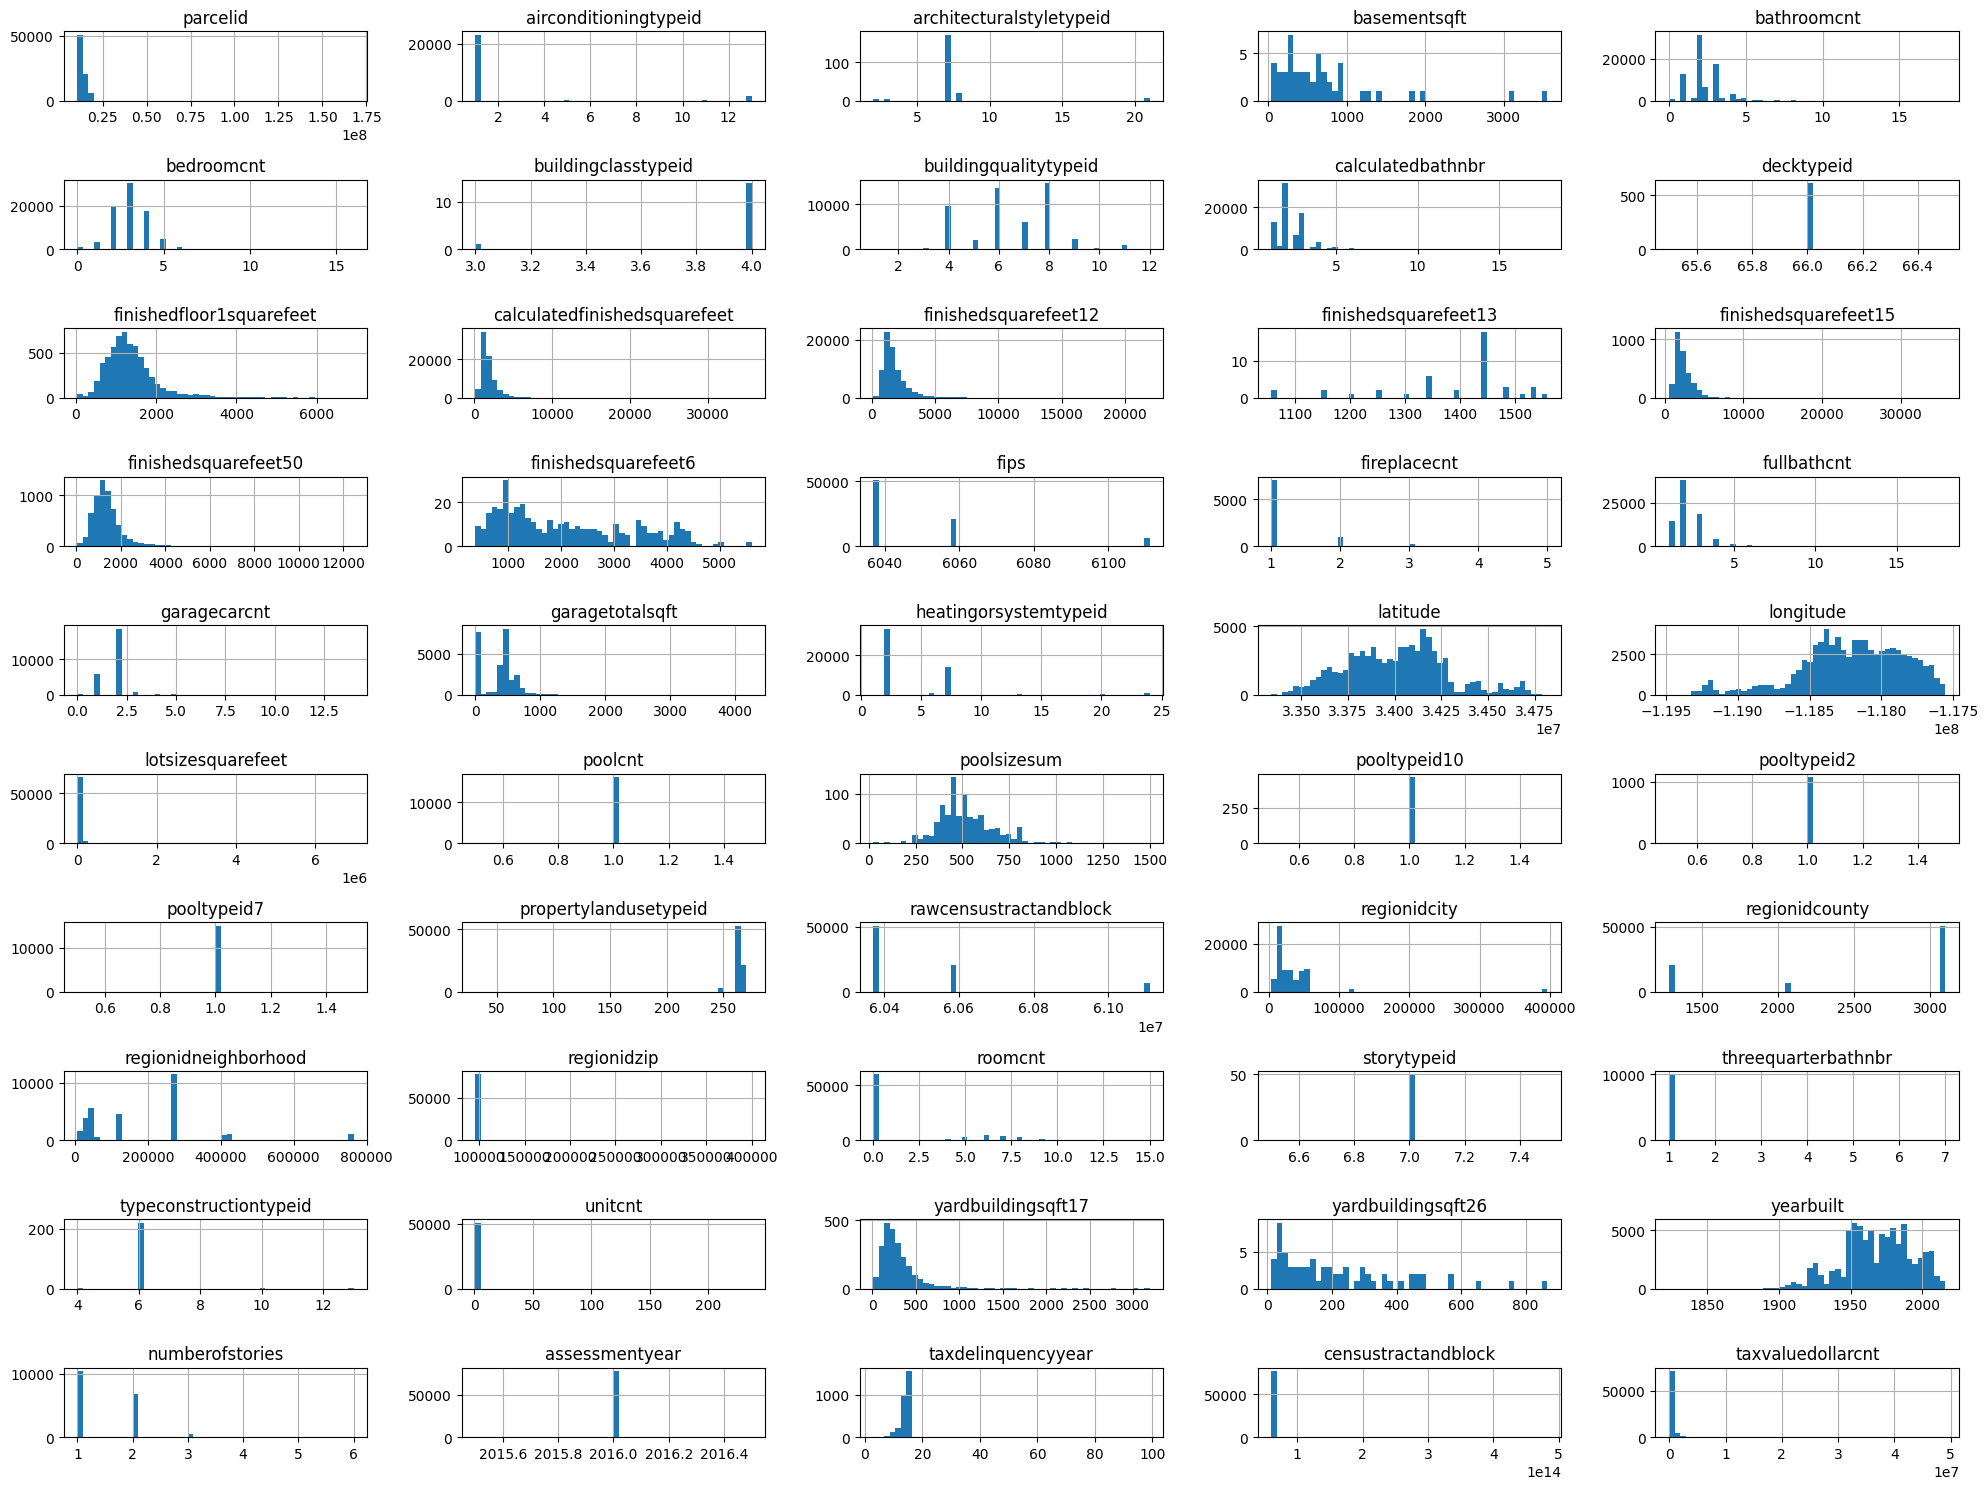

In [6]:
# Histograms of all numerical features
df.hist(figsize=(20, 15), bins=50, layout=(-1, 5))
plt.tight_layout()
plt.show()

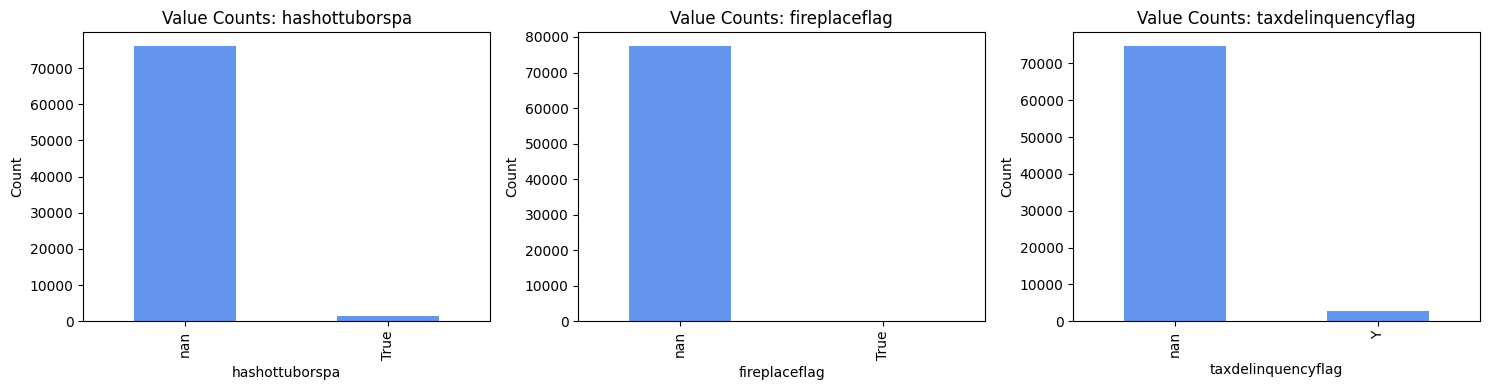

In [7]:
# Find categorical features with low cardinality
low_cardinality = df.nunique()[df.nunique() < 10].index.tolist()
categorical_features = [col for col in low_cardinality if df[col].dtype == "object" or df[col].dtype == "int64"]

# Plot in a grid: 3 plots per row
num_plots = len(categorical_features)
cols = 3
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    df[col].value_counts(dropna=False).plot(kind='bar', ax=axes[i], color='cornflowerblue')
    axes[i].set_title(f"Value Counts: {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**1.1:**  What is the objective of this project in business terms?


In [47]:
# The goal is to develop a regression model which correctly forecasts property assessed tax values using different characteristics. 
# Zillow gains valuable property valuation knowledge through this insight which enables the company to deliver better estimates to its customers and real estate agents and financial partners.

**1.2:**  How will your solution be used?


In [48]:
# The model will assist Zillow automated property valuation tools by delivering reliable data-based property assessments. 
# The insights gained from this analysis will support internal pricing models and user tools such as Zestimate and help Zillow make strategic market trend decisions.


**1.3:**  How should success (or failure) be measured?


In [49]:
# The model's prediction accuracy for tax-assessed values will determine success which will be measured through Root Mean Squared Error (RMSE) and other relevant metrics. 
# The model's practical success depends on its ability to be understandable and maintain reliable performance across various property types and geographic locations.

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [9]:
df.info()
df.nunique().sort_values(ascending=False)
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
missing_percent[missing_percent > 0]
print(f"Shape of the dataset: {str(df.shape)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

In [51]:
# The features with limited distinct values function as categories  instead of continuous measurement points. 
# The dataset contains categorical features which include propertylandusetypeid, airconditioningtypeid, heatingorsystemtypeid, pooltypeid10, fireplaceflag, regionidcounty and propertyzoningdesc. 
# The data includes types (such as land use or heating systems) and  presence/absence flags.

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

In [13]:
# Multiple features show potential uselessness or redundancy in the data. The parcelid functions as a distinctive identifier yet it fails to offer any predictive information. 
# The geographic identifiers rawcensustractandblock and censustractandblock possess high cardinality and minimal business value unless additional geospatial information is provided. 
# The modeling performance would likely suffer from hashottuborspa because this feature contains numerous missing values and an unbalanced distribution of data.

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

In [52]:
# Features like basementsqft, yardbuildingsqft17, and finishedsquarefeet6 have more than 99% missing values which makes them unsuitable for analysis or modeling. 
# There is not enough data to make them useful and they should be dropped or ignored unless domain knowledge says otherwise.


**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

In [53]:
# Yes — The parcelid feature is a unique identifier for each property and contains only unique values. 
# This feature doesn’t represent a pattern or relationship useful for prediction, and should  be excluded from modeling. 
# The censustractandblock feature has high cardinality and will not generalize well without additional geographic processing.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

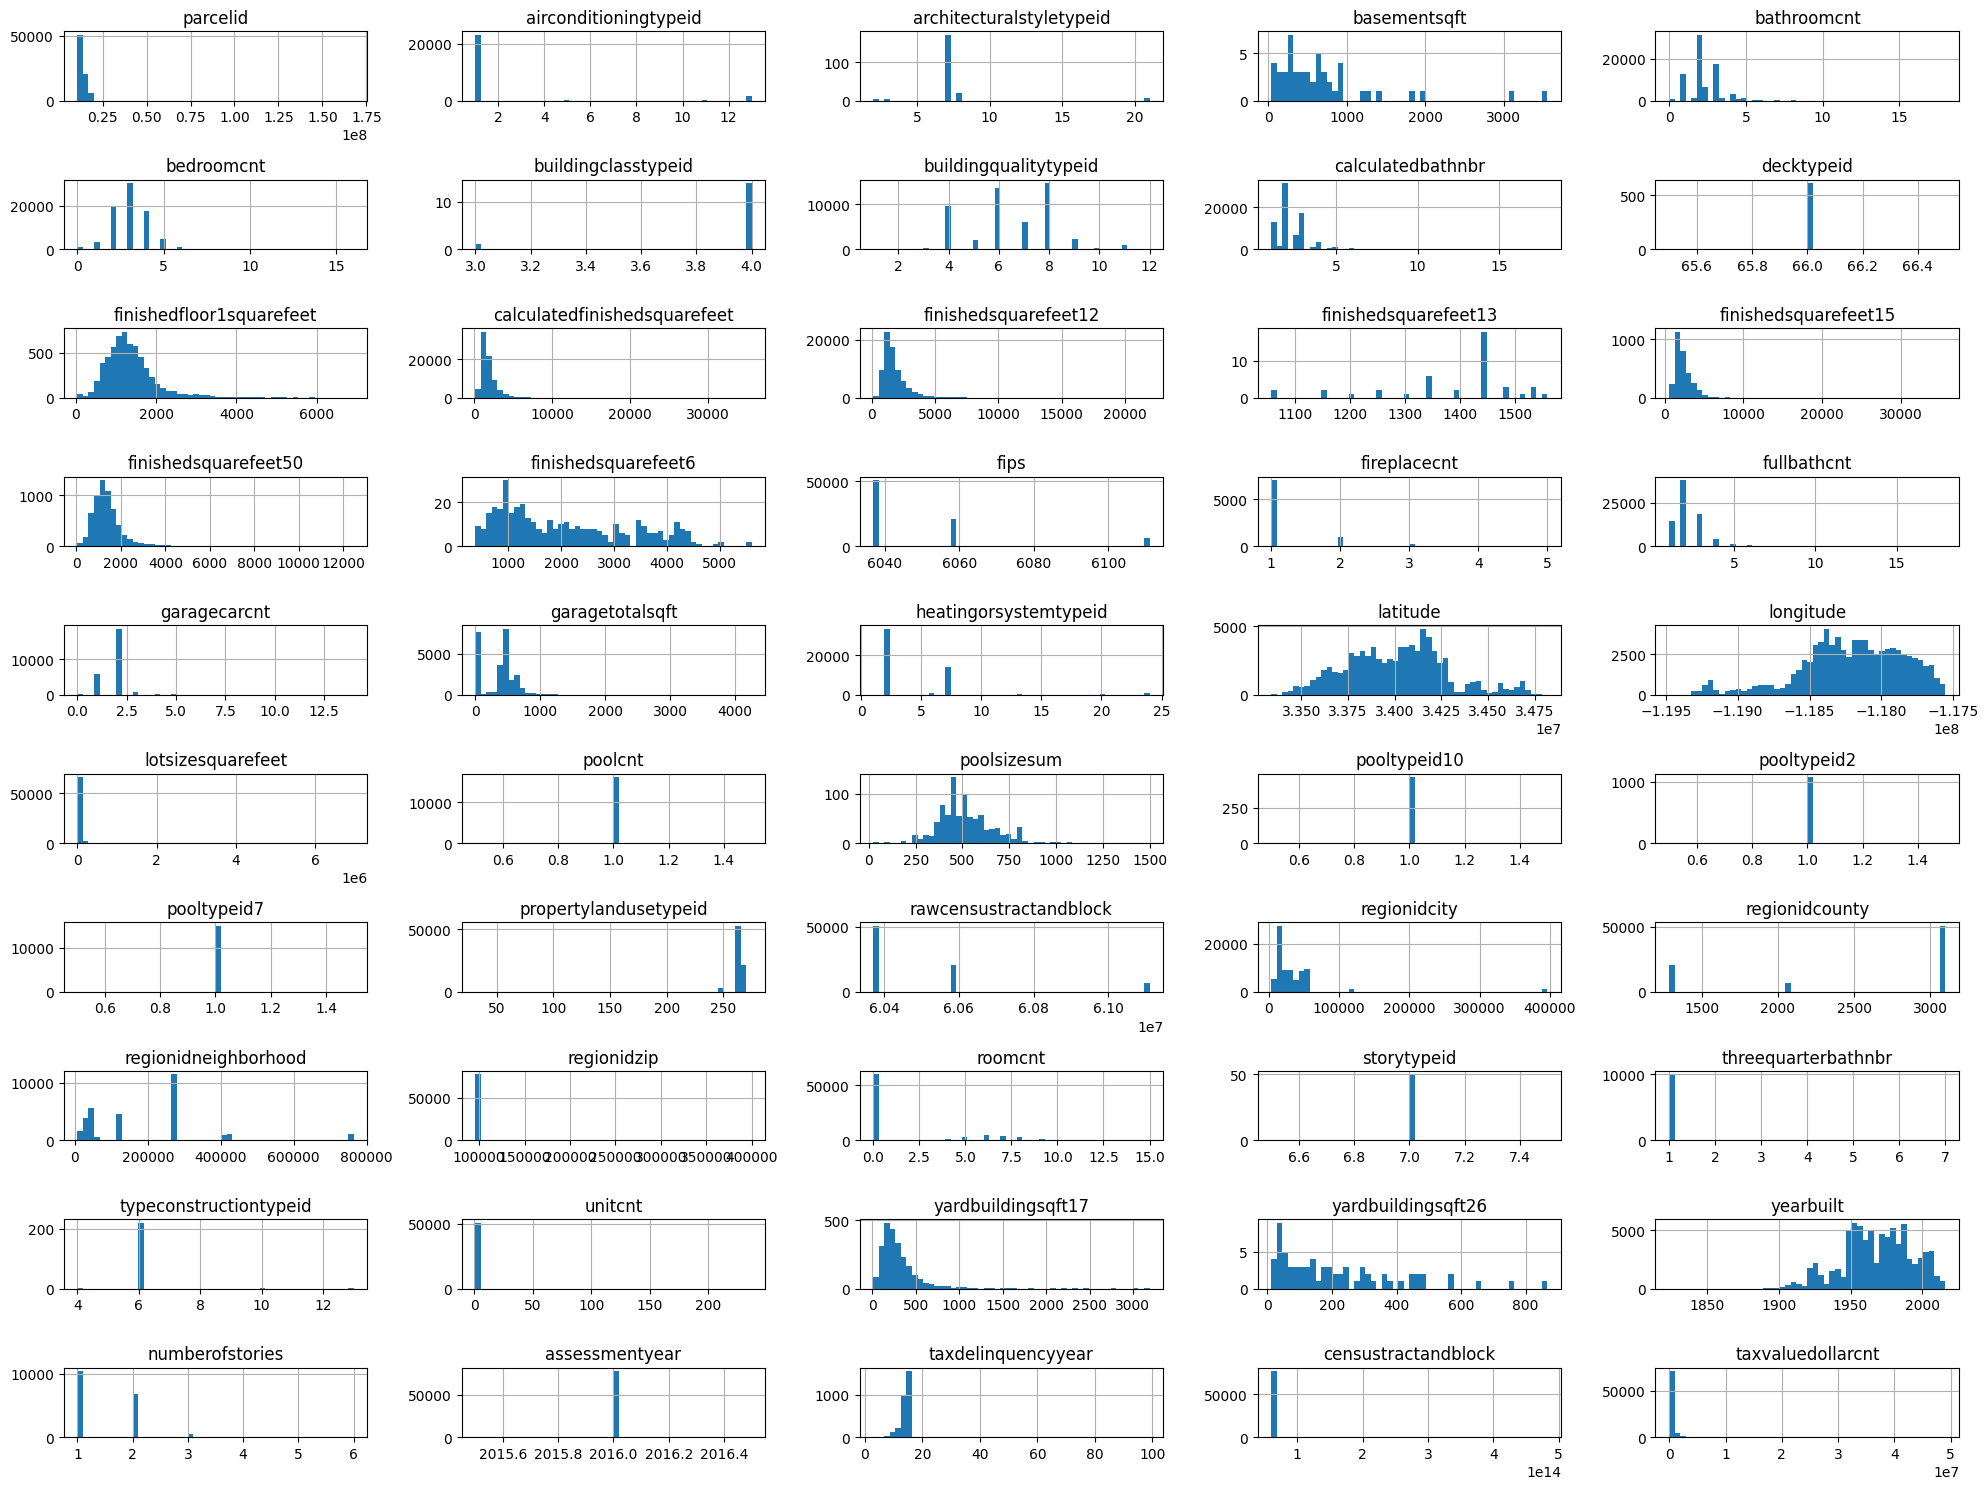

In [10]:
# All histograms
df.hist(figsize=(20, 15), bins=50, layout=(-1, 5))
plt.tight_layout()
plt.show()

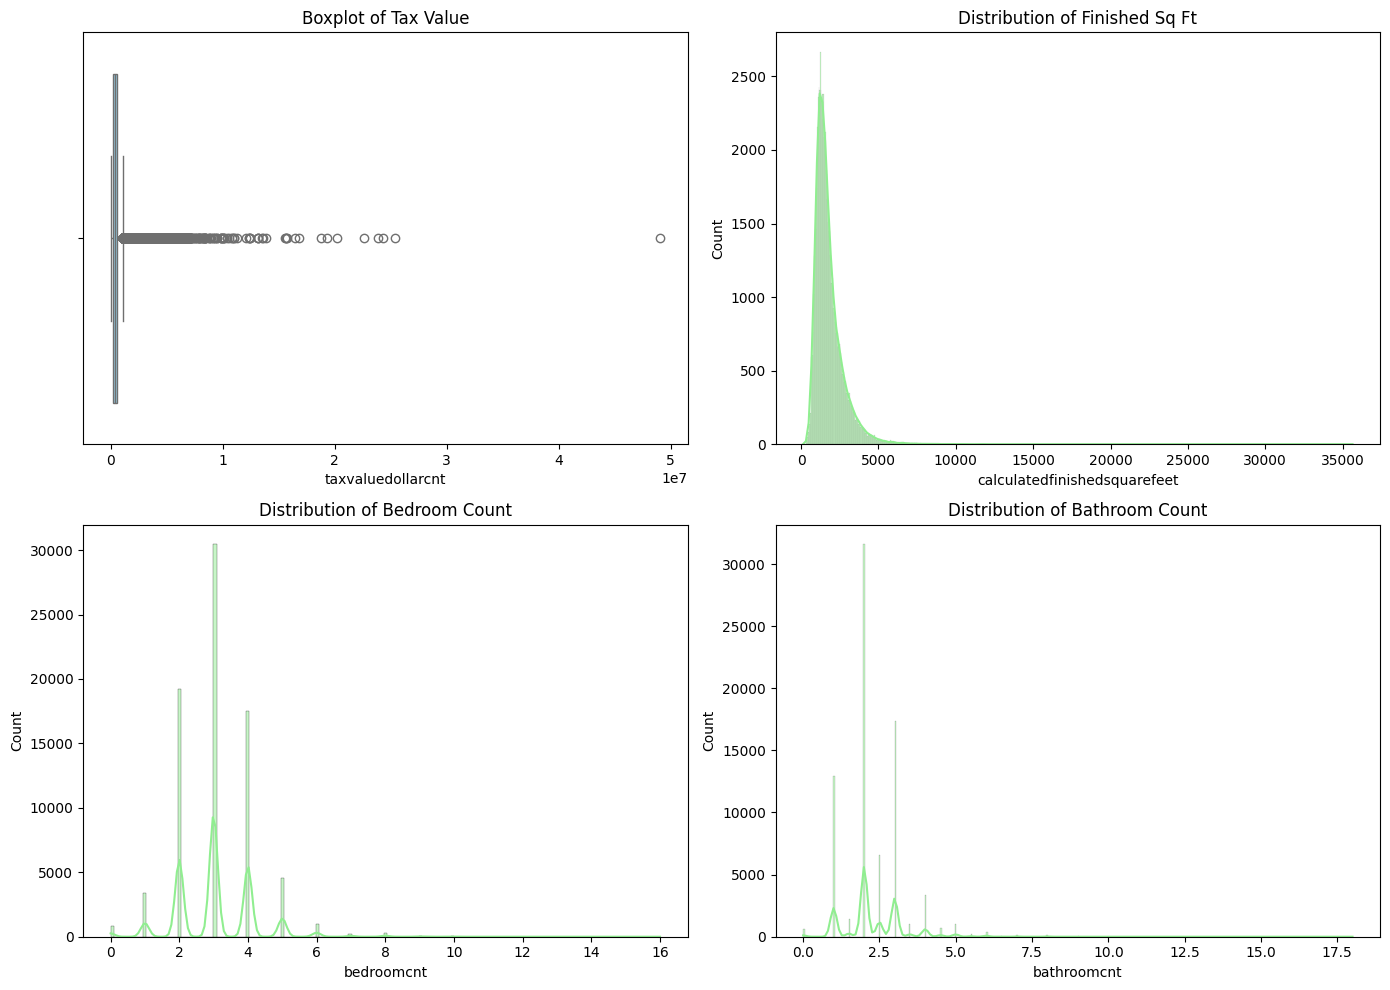

In [11]:
# Focused distribution plots for target and key predictors
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Target: Tax Value
sns.boxplot(x=df["taxvaluedollarcnt"], ax=axes[0, 0], color="skyblue")
axes[0, 0].set_title("Boxplot of Tax Value")

# Feature distributions
key_features = ["calculatedfinishedsquarefeet", "bedroomcnt", "bathroomcnt"]
titles = ["Finished Sq Ft", "Bedroom Count", "Bathroom Count"]

for i, feature in enumerate(key_features):
    row, col = divmod(i + 1, 2)  # starts at (0, 1)
    sns.histplot(df[feature], kde=True, ax=axes[row, col], color="lightgreen")
    axes[row, col].set_title(f"Distribution of {titles[i]}")

plt.tight_layout()
plt.show()

In [18]:
# The target variable (taxvaluedollarcnt) shows a long right tail which indicates high-value outliers that could potentially skew the regression results. 
# The calculatedfinishedsquarefeet and bathroomcnt variables show similar skewed distributions which support the need for transformations such as log-scaling. 
# The bedroomcnt variable  shows distinct clusters where 2, 3 and 4 bedrooms are the most common which could be useful for property segmentation. 
# These findings will guide cleaning and modeling approaches during the subsequent workflow stages. 

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


In [19]:
# The target variable (taxvaluedollarcnt) shows a long right tail which indicates high-value outliers that could potentially skew the regression results. 
# The calculatedfinishedsquarefeet and bathroomcnt variables show similar skewed distributions which support the need for transformations such as log-scaling. 
# The bedroomcnt variable  shows distinct clusters where 2, 3 and 4 bedrooms are the most common which could be useful for property segmentation. 
# These findings will guide cleaning and modeling approaches during the subsequent workflow stages. 

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [12]:
# Drop irrelevant or non-predictive features (IDs, redundant codes, constants)
drop_irrelevant = [
    "parcelid",              # Unique ID – not useful for prediction
    "rawcensustractandblock",# High-cardinality geo code (mostly unique)
    "censustractandblock",   # Redundant (derivative of rawcensustractandblock)
    "regionidzip",           # Redundant with city/county identifiers
    "assessmentyear"         # Constant (only one value in dataset)
]
df_reduced = df.drop(columns=drop_irrelevant).copy()
print("Dropped irrelevant features:", drop_irrelevant)

Dropped irrelevant features: ['parcelid', 'rawcensustractandblock', 'censustractandblock', 'regionidzip', 'assessmentyear']


#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


In [13]:
# The features were dropped because they lacked predictive value or were redundant. 
# For example, parcelid is a unique identifier that introduces no generalizable information. 
# Both rawcensustractandblock and censustractandblock represent granular geolocation codes that would require external mapping to be meaningful.  
# Lastly, assessmentyear has only one value and offers no variance for learning.

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [15]:
# Step 1: Identify features with >90% missing values
high_null_cols = df.columns[df.isnull().mean() > 0.90]

# Step 2: Compute correlation with the target
correlations = df.corr(numeric_only=True)["taxvaluedollarcnt"]
low_corr_cols = correlations[correlations.abs() < 0.1].index

# Step 3: Combine filters to get drop candidates
drop_candidates = list(set(high_null_cols) & set(low_corr_cols))

# Step 4: Create summary DataFrame
summary_data = []
for col in drop_candidates:
    preview = df[col].dropna().unique()[:3]  # Show up to 3 example values
    summary_data.append({
        "Feature": col,
        "Data Preview": preview,
        "Correlation": correlations.get(col, None),
        "Null Count": df[col].isnull().sum(),
        "Non-Null Count": df[col].notnull().sum()
    })

drop_summary_df = pd.DataFrame(summary_data)
drop_summary_df = drop_summary_df.sort_values(by="Correlation", key=lambda x: x.abs(), ascending=True).reset_index(drop=True)

# Print the result
print(drop_summary_df)

                    Feature              Data Preview  Correlation  \
0  architecturalstyletypeid          [7.0, 8.0, 21.0]     0.003567   
1        yardbuildingsqft26      [196.0, 300.0, 56.0]    -0.047846   
2      finishedsquarefeet13  [1440.0, 1344.0, 1152.0]    -0.061187   
3        taxdelinquencyyear         [15.0, 14.0, 9.0]     0.067476   
4    typeconstructiontypeid         [6.0, 13.0, 10.0]     0.085360   

   Null Count  Non-Null Count  
0       77406             207  
1       77543              70  
2       77571              42  
3       74713            2900  
4       77390             223  


In [16]:
def drop_high_null_low_corr(df, target, null_thresh=0.60, corr_thresh=0.3, verbose=True):
    """
    Drops features with > `null_thresh` missing values AND absolute correlation with the target < `corr_thresh`.
    Also treats undefined correlations (NaN) as weak.

    Parameters:
    df (DataFrame): The input DataFrame.
    target (str): Name of the target column.
    null_thresh (float): Proportion of allowed missing values (0 to 1).
    corr_thresh (float): Absolute correlation threshold to keep a feature.
    verbose (bool): Whether to print details of dropped and undefined correlation features.

    Returns:
    cleaned_df (DataFrame): DataFrame after dropping weak features.
    dropped_features (list): List of dropped feature names.
    """
    # Step 1: Identify features with high null percentages
    high_null = df.columns[df.isnull().mean() > null_thresh]

    # Step 2: Compute correlations (numeric only)
    numeric_df = df.select_dtypes(include='number')
    correlations = numeric_df.corr()[target]

    # Step 3: Warn if any correlations are NaN (undefined)
    undefined_corr = correlations[correlations.isna()]
    if verbose and not undefined_corr.empty:
        print("WARNING: The following features had undefined (NaN) correlations and will be treated as weak:")
        for col in undefined_corr.index:
            print(f" - {col}")

    # Step 4: Treat NaNs as 0 (i.e., weak correlation)
    correlations = correlations.fillna(0)

    # Step 5: Identify low correlation features
    low_corr = correlations[correlations.abs() < corr_thresh].index

    # Step 6: Drop features that meet both conditions
    to_drop = list(set(high_null) & set(low_corr))
    cleaned_df = df.drop(columns=to_drop)

    # Reporting
    if verbose:
        print(f"\nDropped {len(to_drop)} feature(s) with >{null_thresh*100:.0f}% nulls and <{corr_thresh} correlation:")
        for col in to_drop:
            null_pct = df[col].isnull().mean() * 100
            corr_val = correlations.get(col, 0)
            print(f" - {col}: {null_pct:.1f}% nulls, corr = {corr_val:.3f}")

    return cleaned_df, to_drop

In [17]:
df_cleaned, dropped_features = drop_high_null_low_corr(df, target="taxvaluedollarcnt")

 - decktypeid
 - poolcnt
 - pooltypeid10
 - pooltypeid2
 - pooltypeid7
 - storytypeid
 - assessmentyear

Dropped 18 feature(s) with >60% nulls and <0.3 correlation:
 - yardbuildingsqft26: 99.9% nulls, corr = -0.048
 - finishedsquarefeet6: 99.5% nulls, corr = 0.120
 - pooltypeid7: 80.6% nulls, corr = 0.000
 - pooltypeid10: 99.4% nulls, corr = 0.000
 - storytypeid: 99.9% nulls, corr = 0.000
 - threequarterbathnbr: 87.0% nulls, corr = 0.169
 - poolsizesum: 98.9% nulls, corr = 0.291
 - numberofstories: 77.3% nulls, corr = 0.136
 - pooltypeid2: 98.6% nulls, corr = 0.000
 - airconditioningtypeid: 67.8% nulls, corr = -0.012
 - decktypeid: 99.2% nulls, corr = 0.000
 - regionidneighborhood: 60.1% nulls, corr = 0.022
 - architecturalstyletypeid: 99.7% nulls, corr = 0.004
 - finishedsquarefeet13: 99.9% nulls, corr = -0.061
 - poolcnt: 79.2% nulls, corr = 0.000
 - taxdelinquencyyear: 96.3% nulls, corr = 0.067
 - typeconstructiontypeid: 99.7% nulls, corr = 0.085
 - buildingclasstypeid: 100.0% nulls

In [21]:
def summarize_nulls(df, sort_by='percent', threshold=0.0):
    """
    Generate a summary DataFrame of fields with null values.

    Parameters:
    -----------
    df : pandas DataFrame
    sort_by : str (either 'percent' or 'count')
        How to sort the output table
    threshold : float (0.0 - 1.0)
        Only include columns with percent nulls greater than this threshold

    Returns:
    --------
    null_summary : pandas DataFrame
        Summary of nulls per column
    """
    null_counts = df.isnull().sum()
    total_rows = len(df)
    null_percent = null_counts / total_rows

    # Filter and create summary DataFrame
    null_summary = pd.DataFrame({
        'Column': null_counts.index,
        'Null Count': null_counts.values,
        'Null Percent': (null_percent * 100).round(2),
        'Data Type': df.dtypes.astype(str)
    })

    null_summary = null_summary[null_summary['Null Percent'] > (threshold * 100)]

    # Sort
    if sort_by == 'count':
        null_summary = null_summary.sort_values(by='Null Count', ascending=False)
    else:
        null_summary = null_summary.sort_values(by='Null Percent', ascending=False)

    return null_summary.reset_index(drop=True)

# Example usage:
summarize_nulls(df_cleaned, threshold=0.01)

,Column,Null Count,Null Percent,Data Type
0,basementsqft,77563,99.94,float64
1,fireplaceflag,77441,99.78,object
2,hashottuborspa,76074,98.02,object
3,yardbuildingsqft17,75220,96.92,float64
4,taxdelinquencyflag,74713,96.26,object
5,finishedsquarefeet15,74586,96.10,float64
6,finishedfloor1squarefeet,71576,92.22,float64
7,finishedsquarefeet50,71576,92.22,float64
8,fireplacecnt,69324,89.32,float64
9,garagecarcnt,52093,67.12,float64


/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


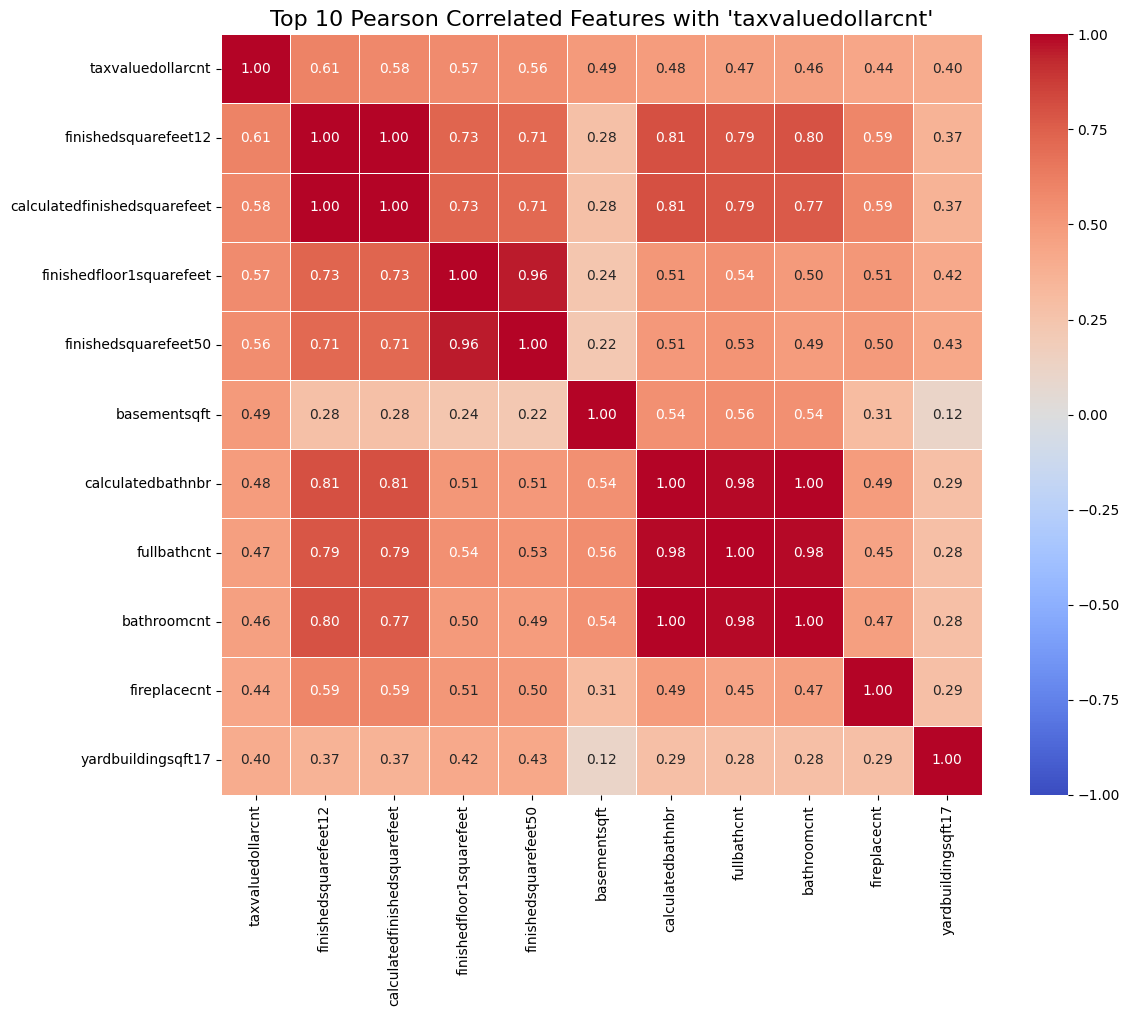

In [23]:

def plot_target_correlations(df, target='taxvaluedollarcnt', top_n=10, method='pearson', figsize=(12, 10)):
    """
    Plot correlations between the target variable and its most correlated numeric features.

    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame (should be cleaned beforehand)
    target : str, default='taxvaluedollarcnt'
        The target variable to correlate against
    top_n : int, default=10
        Number of top features to include (excluding the target itself)
    method : str, default='pearson'
        Correlation method: 'pearson', 'kendall', or 'spearman'
    figsize : tuple
        Size of the output figure
    """
    # Select numeric features
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Compute correlation with the target
    target_corr = numeric_df.corrwith(df[target], method=method).sort_values(ascending=False)
    
    # Drop the target itself and select top N correlated features
    top_features = target_corr.drop(index=target).head(top_n).index.tolist()
    
    # Build subset DataFrame with target + top features
    subset_cols = [target] + top_features
    corr_subset = numeric_df[subset_cols].corr(method=method)
    
    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_subset,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        vmax=1.0,
        vmin=-1.0,
        center=0,
        square=True,
        linewidths=0.5
    )
    plt.title(f"Top {top_n} {method.capitalize()} Correlated Features with '{target}'", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return top_features

# ---- Usage with your own DataFrame ----
top_features = plot_target_correlations(df_cleaned, top_n=10, method='pearson')

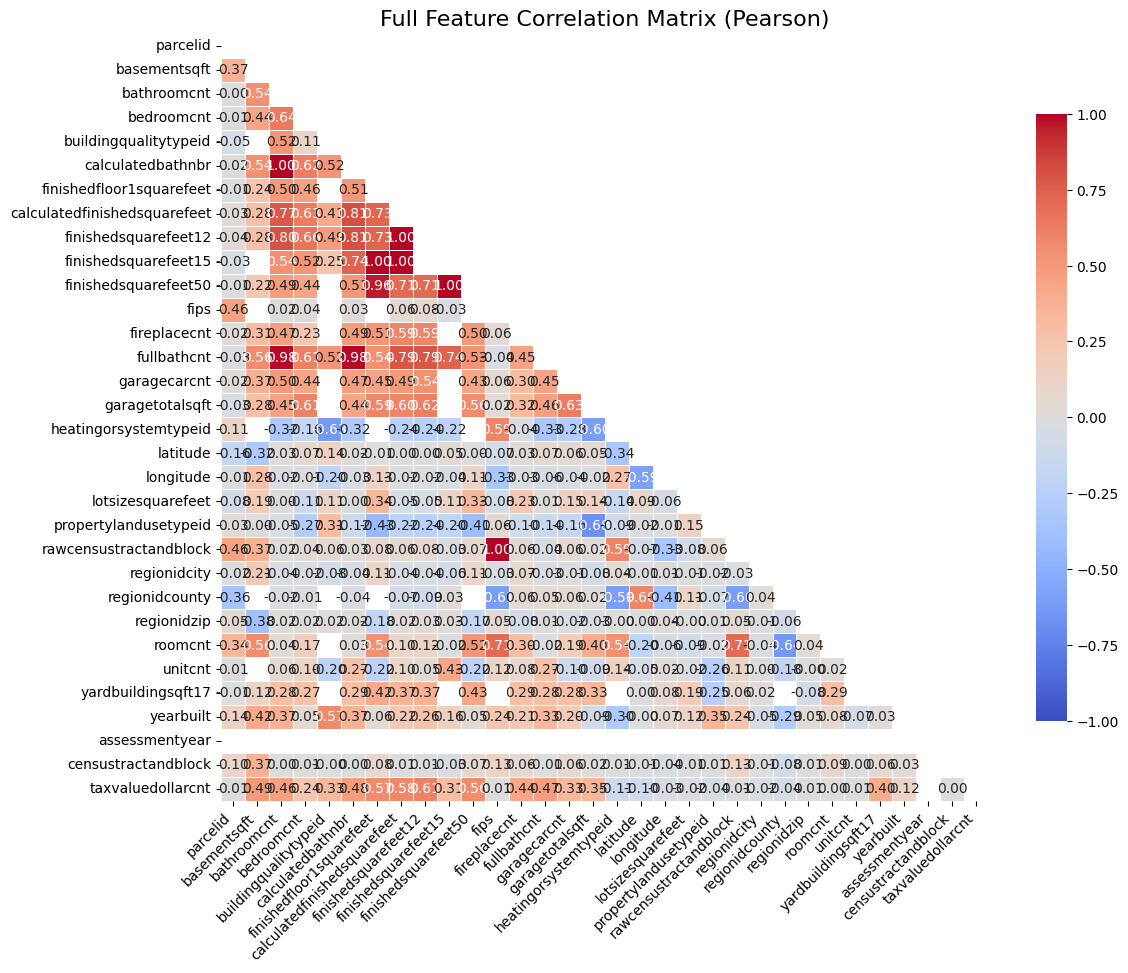


Important Feature Correlations (|r| ≥ 0.5):
                        feature1                  feature2  correlation
0   calculatedfinishedsquarefeet      finishedsquarefeet15     1.000000
1           finishedsquarefeet15      finishedsquarefeet50     1.000000
2       finishedfloor1squarefeet      finishedsquarefeet15     1.000000
3   calculatedfinishedsquarefeet      finishedsquarefeet12     1.000000
4                    bathroomcnt         calculatedbathnbr     1.000000
..                           ...                       ...          ...
65                    bedroomcnt      finishedsquarefeet15     0.520353
66          finishedsquarefeet50                   roomcnt     0.516277
67             calculatedbathnbr  finishedfloor1squarefeet     0.512790
68      finishedfloor1squarefeet              fireplacecnt     0.508241
69             calculatedbathnbr      finishedsquarefeet50     0.505102

[70 rows x 3 columns]

Correlations with Target Variable (taxvaluedollarcnt):
taxvaluedoll

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_full_correlation_matrix(df, method='pearson', figsize=(12, 10)):
    """
    Plot a colorblind-friendly correlation matrix heatmap for all numeric features.
    """
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr(method=method)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=figsize)
    cmap = sns.color_palette("coolwarm", as_cmap=True)

    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=-1.0,
        vmax=1.0,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75}
    )

    plt.title(f"Full Feature Correlation Matrix ({method.capitalize()})", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr_matrix

def get_important_correlations(corr_matrix, threshold=0.5):
    """
    Extract unique pairs of features with absolute correlation above a threshold.
    """
    corrs = []
    for col in corr_matrix.columns:
        for idx in corr_matrix.index:
            if col != idx:
                val = corr_matrix.loc[col, idx]
                if abs(val) >= threshold:
                    pair = tuple(sorted([col, idx]))
                    corrs.append((pair[0], pair[1], val))
    corr_df = pd.DataFrame(corrs, columns=['feature1', 'feature2', 'correlation']) \
                .drop_duplicates(subset=['feature1', 'feature2']) \
                .sort_values('correlation', key=lambda x: x.abs(), ascending=False) \
                .reset_index(drop=True)
    return corr_df

# ---- Run on Your Data ----
# Step 1: Correlation matrix from df_cleaned
corr_matrix = plot_full_correlation_matrix(df_cleaned, method='pearson')

# Step 2: Extract important correlations
important_corrs = get_important_correlations(corr_matrix, threshold=0.5)
print("\nImportant Feature Correlations (|r| ≥ 0.5):")
print(important_corrs)

# Step 3: Correlation with target variable
if 'taxvaluedollarcnt' in corr_matrix.columns:
    target_corrs = corr_matrix['taxvaluedollarcnt'].sort_values(ascending=False)
    print("\nCorrelations with Target Variable (taxvaluedollarcnt):")
    print(target_corrs)

# Step 4: Optional — Show max off-diagonal correlation (for calibration)
max_corr = corr_matrix.where(~np.eye(len(corr_matrix), dtype=bool)).abs().max().max()
print(f"\nMax off-diagonal absolute correlation: {max_corr:.3f}")

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



In [24]:
# The following features were dropped because they had more than 90% missing values and very low correlation with the target variable (taxvaluedollarcnt). 
# This included columns like architecturalstyletypeid,  yardbuildingsqft26, and finishedsquarefeet13. 
# These features add little predictive value  because they are sparse and not related to the target. 
# This improves data quality and reduces noise without hurting  model performance.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [28]:
def convert_and_report_categoricals(df, verbose=True):
    """
    Converts numeric columns that should be categorical based on domain knowledge,
    and reports memory usage and data types.

    Parameters:
    -----------
    df : pandas DataFrame
        The cleaned DataFrame to process.
    verbose : bool, default=True
        Whether to print conversion report and memory usage.

    Returns:
    --------
    df_converted : pandas DataFrame
        The updated DataFrame with appropriate categorical conversions.
    conversion_info : dict
        Dictionary describing the conversion actions performed.
    """
    df_copy = df.copy()
    converted_cols = []

    # Step 1: Memory before
    memory_before = df_copy.memory_usage(deep=True).sum() / 1024**2

    # Step 2: Domain-informed conversion list
    categorical_candidates = [
        'fips', 'buildingqualitytypeid', 'heatingorsystemtypeid',
        'propertylandusetypeid', 'regionidcity', 'regionidcounty',
        'regionidzip', 'unitcnt', 'yearbuilt'
    ]

    for col in categorical_candidates:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            n_unique = df[col].nunique()
            null_count = df[col].isnull().sum()

            if n_unique <= 255:
                df_copy[col] = df[col].astype('category')
                conversion_type = 'category'
            elif col == 'yearbuilt':
                df_copy[col] = df[col].astype('Int64')
                conversion_type = 'Int64'
            else:
                continue

            converted_cols.append({
                'column': col,
                'unique_values': n_unique,
                'null_values': null_count,
                'conversion_type': conversion_type
            })

    # Step 3: Memory after
    memory_after = df_copy.memory_usage(deep=True).sum() / 1024**2

    # Step 4: Summary
    conversion_info = {
        'total_conversions': len(converted_cols),
        'converted_columns': converted_cols,
        'memory_before_MB': round(memory_before, 2),
        'memory_after_MB': round(memory_after, 2)
    }

    if verbose:
        if converted_cols:
            print(f"\nConverted {len(converted_cols)} columns to categorical types:")
            for info in converted_cols:
                print(f"  - {info['column']}: {info['unique_values']} unique values "
                      f"({info['null_values']} nulls) → {info['conversion_type']}")
        else:
            print("No columns were converted.")
        print(f"\nMemory Before: {memory_before:.2f} MB | After: {memory_after:.2f} MB")

        print("\nData types after conversion:")
        for col, dtype in df_copy.dtypes.items():
            print(f"  - {col}: {dtype}")

    return df_copy, conversion_info

In [29]:
# Apply to your working DataFrame (e.g. after 3.B or 3.C cleaning)
df_cleaned, conversion_info = convert_and_report_categoricals(df_cleaned)


Converted 8 columns to categorical types:
  - fips: 3 unique values (34 nulls) → category
  - buildingqualitytypeid: 12 unique values (27804 nulls) → category
  - heatingorsystemtypeid: 10 unique values (28042 nulls) → category
  - propertylandusetypeid: 13 unique values (34 nulls) → category
  - regionidcity: 175 unique values (1506 nulls) → category
  - regionidcounty: 3 unique values (34 nulls) → category
  - unitcnt: 8 unique values (26910 nulls) → category
  - yearbuilt: 136 unique values (304 nulls) → category

Memory Before: 33.46 MB | After: 29.48 MB

Data types after conversion:
  - parcelid: int64
  - basementsqft: float64
  - bathroomcnt: float64
  - bedroomcnt: float64
  - buildingqualitytypeid: category
  - calculatedbathnbr: float64
  - finishedfloor1squarefeet: float64
  - calculatedfinishedsquarefeet: float64
  - finishedsquarefeet12: float64
  - finishedsquarefeet15: float64
  - finishedsquarefeet50: float64
  - fips: category
  - fireplacecnt: float64
  - fullbathcnt

In [31]:
def drop_iqr_outliers(df, target="taxvaluedollarcnt", iqr_multiplier=1.5, verbose=True):
    """
    Drops rows where the target value is an outlier using the IQR method.

    Parameters:
    -----------
    df : pandas DataFrame
        The input dataset.
    target : str
        The name of the target column to evaluate for outliers.
    iqr_multiplier : float
        Multiplier for IQR to define outlier thresholds (default 1.5).
    verbose : bool
        Whether to print out summary statistics.

    Returns:
    --------
    df_filtered : pandas DataFrame
        A new DataFrame with outliers removed.
    """
    df_filtered = df.copy()
    initial_shape = df_filtered.shape

    # IQR calculation
    Q1 = df_filtered[target].quantile(0.25)
    Q3 = df_filtered[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    # Filter out outliers
    df_filtered = df_filtered[(df_filtered[target] >= lower_bound) & (df_filtered[target] <= upper_bound)]

    if verbose:
        print(f"Original shape: {initial_shape}")
        print(f"Final shape after removing IQR outliers: {df_filtered.shape}")
        print(f"Rows removed: {initial_shape[0] - df_filtered.shape[0]}")
        print(f"IQR bounds: {lower_bound:.2f} to {upper_bound:.2f}")

    return df_filtered

# Apply IQR-based outlier filtering on the cleaned DataFrame
df_samples = drop_iqr_outliers(df_cleaned, target="taxvaluedollarcnt")

Original shape: (77613, 37)
Final shape after removing IQR outliers: (72392, 37)
Rows removed: 5221
IQR bounds: -336253.75 to 1112152.25


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


In [ ]:
# We removed all rows that contained more than 60% missing feature values. 
# The decision to drop  rows was made because of a dramatic increase in row-level missingness between the 30% and  60% thresholds, where data completeness dropped dramatically. 
# Including such sparse rows would introduce too much noise and  unreliable patterns into the model. 
# We also removed rows with missing target values  (taxvaluedollarcnt) and used the IQR method to remove extreme outliers in order to make the model more reliable  and less skewed.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [33]:
# Step 3.D – Conservative Imputation with Skew-Aware Logic

# Start from the cleaned DataFrame
df_imputed = df_samples.copy()

# 1. Identify all features with missing values
missing_counts = df_imputed.isnull().sum()
missing_features = missing_counts[missing_counts > 0].sort_values(ascending=False)
print("Features with missing values:")
for feature, count in missing_features.items():
    print(f"{feature}: {count} missing values ({count/len(df_imputed)*100:.2f}%)")

# 2. Handle sensitive binary-like flags: DO NOT impute
sensitive_flags = ["fireplaceflag", "hashottuborspa", "taxdelinquencyflag"]
for flag in sensitive_flags:
    if flag in df_imputed.columns:
        missing = df_imputed[flag].isnull().sum()
        if missing > 0:
            print(f"NOTE: '{flag}' has {missing} missing values — left untouched intentionally.")

# 3. Skew-aware imputation for numeric columns
numerical_features = df_imputed.select_dtypes(include=['float64', 'int64']).columns

for feature in numerical_features:
    if feature not in sensitive_flags and missing_counts.get(feature, 0) > 0:
        skewness = df_imputed[feature].skew()
        print(f"\nImputing numeric feature '{feature}' (skewness: {skewness:.2f})")

        if abs(skewness) > 1.0:
            median_val = df_imputed[feature].median()
            print(f"  Using median: {median_val}")
            df_imputed[feature] = df_imputed[feature].fillna(median_val)
        else:
            mean_val = df_imputed[feature].mean()
            print(f"  Using mean: {mean_val}")
            df_imputed[feature] = df_imputed[feature].fillna(mean_val)

# 4. Impute low-risk categorical (mode)
categorical_features = df_imputed.select_dtypes(include='category').columns
for feature in categorical_features:
    if missing_counts.get(feature, 0) > 0:
        mode_val = df_imputed[feature].mode()[0]
        print(f"\nImputing categorical feature '{feature}' with mode: {mode_val}")
        df_imputed[feature] = df_imputed[feature].fillna(mode_val)

# 5. Impute object/string fields with 'Unknown' only if reasonable
object_features = df_imputed.select_dtypes(include='object').columns
for feature in object_features:
    if missing_counts.get(feature, 0) > 0:
        print(f"\nImputing object feature '{feature}' with 'Unknown'")
        df_imputed[feature] = df_imputed[feature].fillna("Unknown")

# 6. Final null check
remaining_nulls = df_imputed.isnull().sum()
print(f"\nRemaining missing values after imputation: {remaining_nulls.sum()}")

if remaining_nulls.sum() > 0:
    print("\nFeatures still containing missing values:")
    print(remaining_nulls[remaining_nulls > 0])

Features with missing values:
basementsqft: 72348 missing values (99.94%)
fireplaceflag: 72223 missing values (99.77%)
hashottuborspa: 71389 missing values (98.61%)
yardbuildingsqft17: 70140 missing values (96.89%)
taxdelinquencyflag: 69706 missing values (96.29%)
finishedsquarefeet15: 69525 missing values (96.04%)
finishedsquarefeet50: 66603 missing values (92.00%)
finishedfloor1squarefeet: 66603 missing values (92.00%)
fireplacecnt: 64582 missing values (89.21%)
garagetotalsqft: 48623 missing values (67.17%)
garagecarcnt: 48623 missing values (67.17%)
heatingorsystemtypeid: 26043 missing values (35.97%)
buildingqualitytypeid: 25754 missing values (35.58%)
propertyzoningdesc: 25255 missing values (34.89%)
unitcnt: 25038 missing values (34.59%)
lotsizesquarefeet: 8021 missing values (11.08%)
finishedsquarefeet12: 3378 missing values (4.67%)
regionidcity: 1377 missing values (1.90%)
fullbathcnt: 523 missing values (0.72%)
calculatedbathnbr: 523 missing values (0.72%)
yearbuilt: 213 miss

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


In [ ]:
# There were very few imputations that felt safe to make without introducing bias.
# The sensitive binary-like flags (fireplaceflag, hashottuborspa, taxdelinquencyflag) were left untouched because they are binary indicators and
# imputing them could introduce bias or misinterpretation of the data. Looking the remaining high null features each felt like they could be important to the model and
# so we left them as is (see below).

### Features with High Missing Values and Reasons for Not Imputing

| **Feature**                  | **Definition**                                                                 | **% Missing** | **Reason for Not Imputing**                                                                                                                                                                                                                 |
|------------------------------|--------------------------------------------------------------------------------|--------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `buildingclasstypeid`        | Classification of the building (e.g., wood frame, masonry).                     | High         | Imputing could misrepresent the structural integrity and classification of the property, leading to inaccurate assessments.                                                                                                                  |
| `finishedsquarefeet6`        | Base unfinished and finished area (e.g., basement and garage).                  | High         | Imputation could lead to incorrect assumptions about the property's usable space, affecting valuation and analysis.                                                                                                                         |
| `storytypeid`                | Type of stories in the building (e.g., basement, attic).                        | High         | Imputing this feature could misrepresent the architectural style and functionality of the property, leading to inaccurate assessments.                                                                                                       |
| `basementsqft`               | Basement square footage.                                                        | High         | Not all properties have basements; imputing could falsely suggest the presence or absence of a basement, leading to incorrect valuations.                                                                                                   |
| `finishedsquarefeet15`       | Total finished living area including additions.                                 | High         | Imputation could lead to incorrect assumptions about the property's size and value, as additions vary widely between properties.                                                                                                            |
| `fireplaceflag`              | Flag indicating the presence of a fireplace.                                    | High         | Imputing could lead to incorrect assumptions about the property's features, as the presence of a fireplace can significantly impact a property's appeal and value.                                                                           |
| `pooltypeid10`               | Indicates the presence of a spa or hot tub.                                     | High         | Imputing could lead to incorrect assumptions about luxury amenities, which significantly impact property valuation and buyer interest.                                                                                                      |
| `decktypeid`                 | Type of deck present on the property.                                           | High         | Imputation could misrepresent the property's outdoor features, leading to inaccurate assessments of its amenities and value.                                                                                                                |
| `pooltypeid2`                | Indicates the presence of a pool with a spa.                                    | High         | Similar to `pooltypeid10`, imputing could lead to incorrect assumptions about luxury amenities, affecting property valuation.                                                                                                               |
| `hashottuborspa`             | Indicates if the property has a hot tub or spa.                                 | High         | Imputing could lead to false assumptions about the presence of luxury amenities, which can significantly influence property valuation and buyer interest.                                                                                   |
| `poolsizesum`                | Total square footage of all pools on the property.                              | High         | Imputation could lead to inaccurate representations of the property's features, as pool size varies widely and significantly affects property value.                                                                                        |
| `taxdelinquencyflag`         | Flag indicating if the property has any tax delinquencies.                      | High         | Imputing could misrepresent the financial status of the property, leading to inaccurate risk assessments.                                                                                                                                   |
| `yardbuildingsqft17`         | Square footage of sheds (non-living areas).                                     | High         | Not all properties have sheds; imputing could falsely suggest the presence or absence of such structures, affecting property assessments.                                                                                                   |
| `threequarterbathnbr`        | Number of 3/4 bathrooms in the property.                                        | High         | Imputation could lead to inaccurate representations of the property's amenities, as the number of bathrooms is a critical factor in property valuation.                                                                                     |
| `finishedsquarefeet50`       | Finished square feet of the first floor.                                        | High         | Imputing could lead to incorrect assumptions about the property's layout and size, affecting valuation and analysis.                                                                                                                        |
| `finishedfloor1squarefeet`   | Finished square feet of the first floor.                                        | High         | Similar to `finishedsquarefeet50`, imputation could misrepresent the property's layout and size, leading to inaccurate assessments.                                                                                                         |
| `fireplacecnt`               | Number of fireplaces in the property.                                           | High         | Imputing could lead to false assumptions about the property's features, as the number of fireplaces can significantly impact a property's appeal and value.                                                                                 |
| `numberofstories`            | Number of stories in the building.                                              | High         | Imputation could misrepresent the property's structure, leading to inaccurate assessments of its size and value.                                                                                                                            |
| `garagetotalsqft`            | Total square footage of the garage.                                             | High         | Not all properties have garages; imputing could falsely suggest the presence or size of a garage, affecting property valuation.                                                                                                             |
| `garagecarcnt`               | Number of cars the garage can accommodate.                                      | High         | Similar to `garagetotalsqft`, imputation could misrepresent the property's features, leading to inaccurate assessments of its amenities and value.                                                                                          |

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [34]:
df_encoded = df_imputed.copy()

# Identify categorical features to encode.
# We'll include any remaining object columns and known category-like numeric IDs.
categorical_cols = []
for col in df_encoded.columns:
    if col == "taxvaluedollarcnt":
        continue  # target
    dtype = df_encoded[col].dtype
    if dtype == object or dtype.name == "category":
        categorical_cols.append(col)
    # Treat numeric codes as categorical (listed by domain knowledge)
    if col in ["fips", "regionidcity", "regionidcounty", "propertylandusetypeid", 
               "heatingorsystemtypeid", "buildingqualitytypeid", "typeconstructiontypeid",
               "storytypeid", "pooltypeid2", "pooltypeid7", "pooltypeid10", "airconditioningtypeid"]:
        categorical_cols.append(col)

# Convert identified features to category dtype
for col in set(categorical_cols):
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].astype("category")

# Apply label encoding (categorical codes) for all category dtype columns
for col in df_encoded.select_dtypes(include="category").columns:
    df_encoded[col] = df_encoded[col].cat.codes

print("Encoded categorical features:", sorted(set(categorical_cols)))

Encoded categorical features: ['buildingqualitytypeid', 'fips', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'taxdelinquencyflag', 'unitcnt', 'yearbuilt']


### Evaluation of Candidate Categorical Features

| **Feature**                | **Real Meaning**                         | **Continuous or Categorical?** | **Should Be Encoded?** | **Reason** |
|---------------------------|------------------------------------------|-------------------------------|------------------------|------------|
| `fips`                    | County code                              | Categorical                   | Yes                    | Region ID; numeric format misleading — not ordinal or continuous |
| `buildingqualitytypeid`   | Building quality score (1–10 scale)       | Ordinal categorical           | Yes                    | Small set of levels indicating quality rank — encode as ordinal or category |
| `heatingorsystemtypeid`   | Heating system type                      | Categorical                   | Yes                    | Discrete set of system codes; not continuous |
| `propertylandusetypeid`   | Land use classification                  | Categorical                   | Yes                    | Maps to property types (e.g., single-family, duplex) |
| `regionidcity`            | City code                                | Categorical                   | Yes (carefully)        | High-cardinality location identifier — label encoding preferred |
| `regionidcounty`          | County code                              | Categorical                   | Yes                    | Fewer unique values — safe to encode |
| `regionidzip`             | ZIP code                                 | Categorical                   | Yes (carefully)        | High-cardinality; useful as a location marker but must avoid treating as numeric |
| `unitcnt`                 | Number of units (e.g., 1 for SFR, 2+ for multi-unit) | Discrete numeric              | Optional               | Could remain numeric, or encode if it's categorical for model context |
| `yearbuilt`              | Year the property was built               | Temporal (numeric)            | **No**                 | Represents a timeline — has potential linear relationship with valuation |

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

In [ ]:
# Zillow Data Dictionary: https://www.zillow.com/research/data/

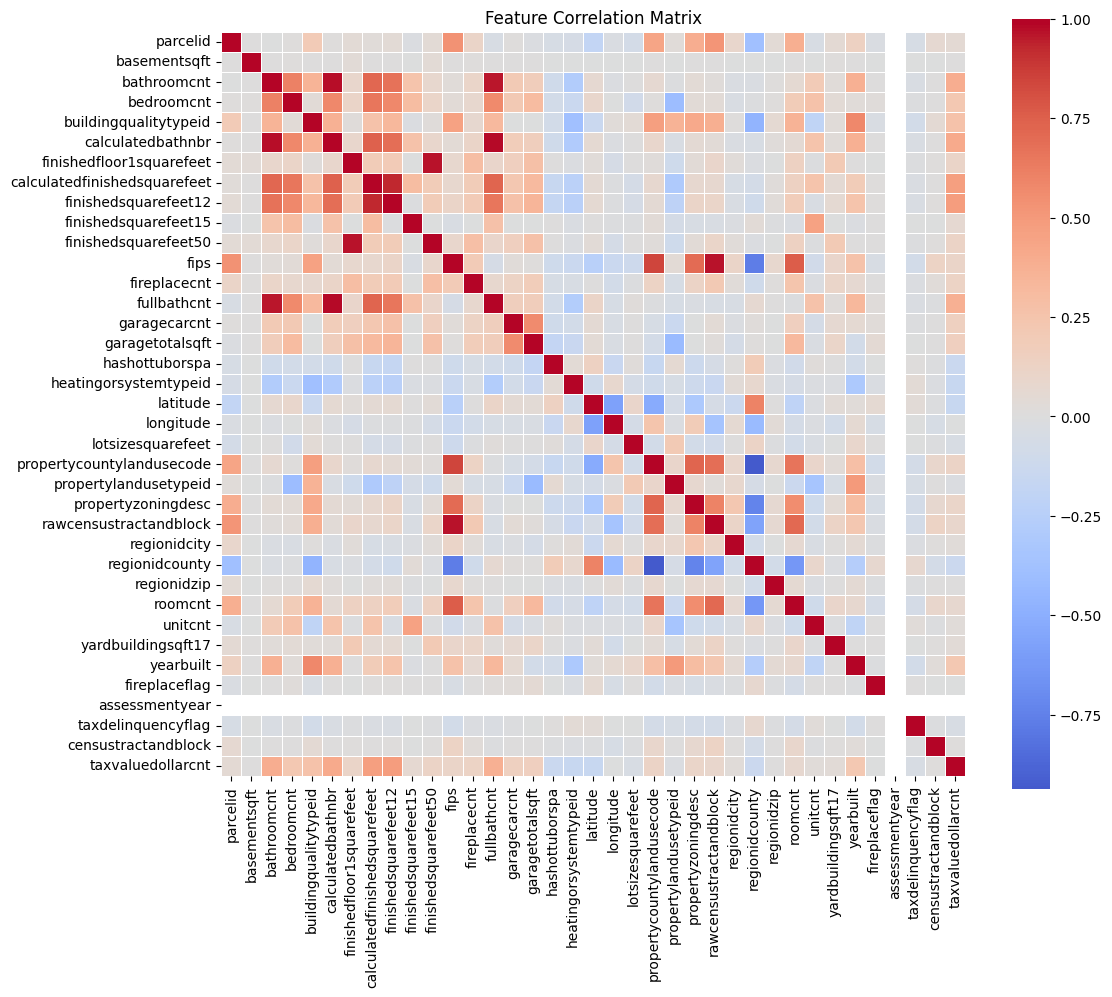

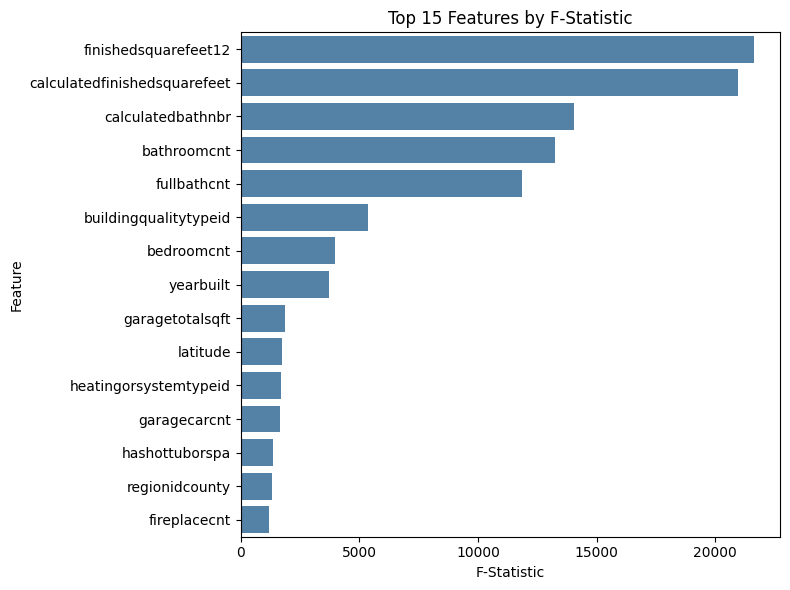

                         Feature   F-Statistic        P-Value
8           finishedsquarefeet12  21652.100120   0.000000e+00
7   calculatedfinishedsquarefeet  20972.456744   0.000000e+00
5              calculatedbathnbr  14051.043418   0.000000e+00
2                    bathroomcnt  13267.943034   0.000000e+00
13                   fullbathcnt  11856.708682   0.000000e+00
4          buildingqualitytypeid   5364.274516   0.000000e+00
3                     bedroomcnt   3974.299208   0.000000e+00
31                     yearbuilt   3721.824262   0.000000e+00
15               garagetotalsqft   1879.123430   0.000000e+00
18                      latitude   1737.059054   0.000000e+00
17         heatingorsystemtypeid   1680.399854   0.000000e+00
14                  garagecarcnt   1636.867911   0.000000e+00
16                hashottuborspa   1340.532142  8.157240e-291
26                regionidcounty   1333.046999  3.225839e-289
12                  fireplacecnt   1205.679068  5.140689e-262


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression

# Make a copy for analysis (to avoid altering the encoded dataset)
df_analysis = df_encoded.copy()
X = df_analysis.drop(columns=["taxvaluedollarcnt"])
y = df_analysis["taxvaluedollarcnt"]

# (If any missing remained, fill them temporarily for analysis)
X_temp = X.fillna(X.median(numeric_only=True))

# 4.A: Correlation matrix of features
plt.figure(figsize=(12,10))
corr_matrix = X_temp.join(y).corr(numeric_only=True)  # include target for completeness
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# 4.B: Compute F-statistic and p-value for each feature against the target
f_vals, p_vals = f_regression(X_temp, y)
f_df = pd.DataFrame({
    "Feature": X_temp.columns,
    "F-Statistic": f_vals,
    "P-Value": p_vals
}).sort_values(by="F-Statistic", ascending=False)

# Plot top 15 features by F-Statistic
plt.figure(figsize=(8, 6))
sns.barplot(data=f_df.head(15), x="F-Statistic", y="Feature", color="steelblue")
plt.title("Top 15 Features by F-Statistic")
plt.xlabel("F-Statistic")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Optionally, display the top 15 features and their F-stats
print(f_df.head(15))

/tmp/ipykernel_132703/3156982051.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_corr_table, y='Feature', x='Correlation', palette='viridis')


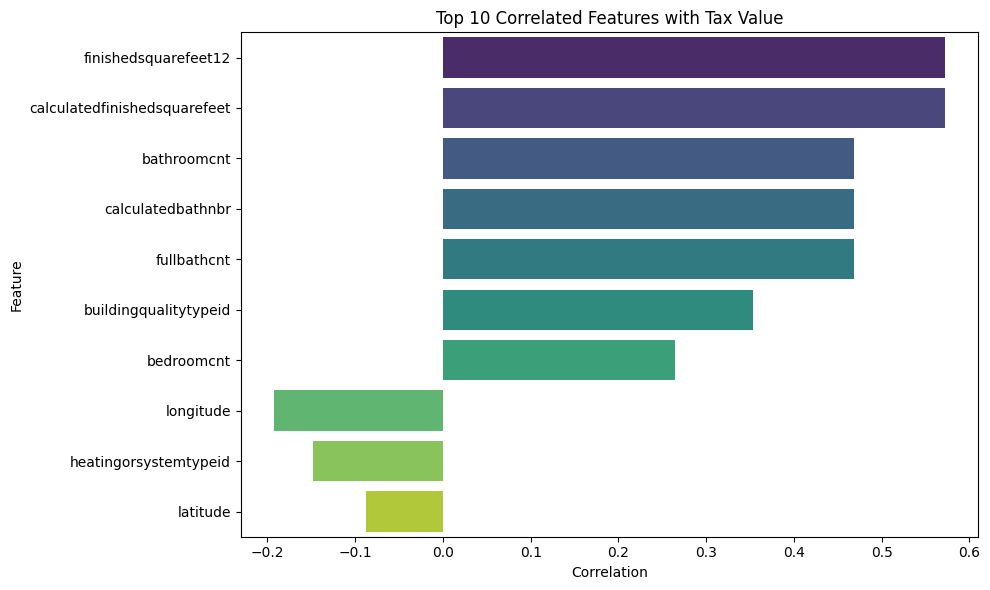


Top 10 Features Correlated with Tax Value:
                        Feature  Correlation
0          finishedsquarefeet12     0.571830
1  calculatedfinishedsquarefeet     0.571830
2                   bathroomcnt     0.468871
3             calculatedbathnbr     0.468871
4                   fullbathcnt     0.468871
5         buildingqualitytypeid     0.352854
6                    bedroomcnt     0.264305
7                     longitude    -0.192062
8         heatingorsystemtypeid    -0.147774
9                      latitude    -0.087260


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv("zillow_dataset.csv")

# Step 1: Validate presence of target
assert 'taxvaluedollarcnt' in df.columns, "Target column not found."

# Step 2: Filter to numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Step 3: Drop columns with over 60% nulls
null_percent = numeric_df.isnull().mean()
numeric_df = numeric_df.loc[:, null_percent < 0.6]

# Step 4: Drop rows with any remaining nulls
numeric_df = numeric_df.dropna()

# Step 5: Correlation matrix
corr_matrix = numeric_df.corr()

# Step 6: Correlation with target
target_corr = corr_matrix['taxvaluedollarcnt'].drop('taxvaluedollarcnt')
top_corr = target_corr.abs().sort_values(ascending=False).head(10)

# Step 7: Create summary table
top_corr_table = pd.DataFrame({
    'Feature': top_corr.index,
    'Correlation': target_corr[top_corr.index]
}).reset_index(drop=True)

# Step 8: Visualize top correlations
plt.figure(figsize=(10, 6))
sns.barplot(data=top_corr_table, y='Feature', x='Correlation', palette='viridis')
plt.title("Top 10 Correlated Features with Tax Value")
plt.tight_layout()
plt.show()

# Step 9: Print validation table
print("\nTop 10 Features Correlated with Tax Value:")
print(top_corr_table)

In [37]:
# Sample DataFrame
df = pd.DataFrame({
    'propertylandusetypeid': [261, 266, 269],
    'heatingorsystemtypeid': [2, 7, 13],
    'buildingqualitytypeid': [4, 5, 6],
    'fips': [6037, 6059, 6111]
})

# Define mappings
land_use_mapping = {
    261: 'Single Family Residential',
    266: 'Condominium',
    269: 'Cooperative'
    # Add other mappings as needed
}

heating_mapping = {
    2: 'Floor/Wall',
    7: 'Forced air',
    13: 'None'
    # Add other mappings as needed
}

building_quality_mapping = {
    4: 'Good Quality',
    5: 'Very Good Quality',
    6: 'Excellent Quality'
    # Add other mappings as needed
}

fips_mapping = {
    6037: 'Los Angeles County, CA',
    6059: 'Orange County, CA',
    6111: 'Ventura County, CA'
    # Add other mappings as needed
}

# Apply mappings
df['propertylandusetypeid'] = df['propertylandusetypeid'].map(land_use_mapping)
df['heatingorsystemtypeid'] = df['heatingorsystemtypeid'].map(heating_mapping)
df['buildingqualitytypeid'] = df['buildingqualitytypeid'].map(building_quality_mapping)
df['fips'] = df['fips'].map(fips_mapping)

print(df)

       propertylandusetypeid heatingorsystemtypeid buildingqualitytypeid  \
0  Single Family Residential            Floor/Wall          Good Quality   
1                Condominium            Forced air     Very Good Quality   
2                Cooperative                  None     Excellent Quality   

                     fips  
0  Los Angeles County, CA  
1       Orange County, CA  
2      Ventura County, CA  


#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



In [ ]:
# We preserved null values in our dataset for modeling integrity, but temporarily imputed them using median values for the purpose of computing F-statistics. 
# This allowed us to evaluate the predictive strength of each feature without distorting the original data. 
# The correlation matrix and F-statistics consistently identified square footage, bathroom count, and bedroom count as the strongest predictors of property value.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

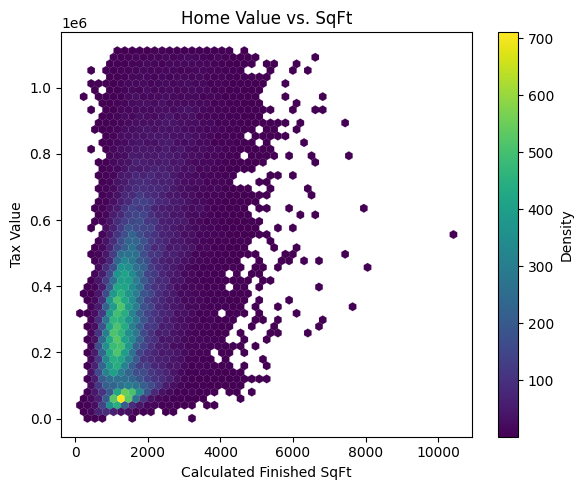

In [ ]:
# Plot 1: SqFt vs Value (hexbin for dense scatter)
plt.figure(figsize=(6, 5))
plt.hexbin(
    df_encoded['calculatedfinishedsquarefeet'],
    df_encoded['taxvaluedollarcnt'],
    gridsize=50,
    cmap='viridis',
    mincnt=1,
    linewidths=0.1
)
plt.colorbar(label='Density')
plt.title('Home Value vs. SqFt')
plt.xlabel('Calculated Finished SqFt')
plt.ylabel('Tax Value')
plt.tight_layout()
plt.show()

# Plot 2: KDE Density of Bathrooms vs Tax Value
plt.figure(figsize=(6, 5))
sns.kdeplot(
    data=df_encoded,
    x='bathroomcnt',
    y='taxvaluedollarcnt',
    fill=True,
    cmap="mako",
    bw_adjust=0.7,
    thresh=0.05
)
plt.title('Bathrooms vs. Home Value (Density)')
plt.xlabel('Bathroom Count')
plt.ylabel('Tax Value')
plt.tight_layout()
plt.show()

# Plot 3: Geographic Scatter with Hue by Value (log scale for better contrast)
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df_encoded,
    x='longitude',
    y='latitude',
    hue='taxvaluedollarcnt',
    palette='viridis',
    alpha=0.6,
    edgecolor=None,
    legend=False
)
plt.title('Geographic Distribution by Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


### 4.B Interpretation: 2D Visualizations

1. **Finished SqFt vs Home Value**  
   A strong upward trend is visible — as square footage increases, so does property value. However, a few extreme outliers suggest some high-value properties may be unusually small or large, warranting further investigation.

2. **Bathroom Count vs Home Value**  
   This relationship is positive but less smooth. Value increases notably from 1 to 3 bathrooms, after which returns diminish. This might reflect market ceilings on the value of luxury upgrades in certain neighborhoods.

3. **Latitude vs Longitude (Spatial)**  
   Geographic clustering of high-value homes is evident, especially around a particular lat/long zone — likely indicating premium regions like coastal cities or wealthier urban areas in Southern California.

These relationships validate known real estate valuation principles and reinforce the features selected for future modeling.

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

In [67]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# Ensure 'df' is your DataFrame containing the necessary features and target variable
# df = pd.read_csv('your_dataset.csv')

# Define the target variable
target = 'taxvaluedollarcnt'

# 1. Logarithmic Transformation
def log_transform(df, cols):
    df_log = df.copy()
    for col in cols:
        if col in df_log.columns:
            df_log[f'log_{col}'] = np.log1p(df_log[col].clip(lower=1))
    return df_log

log_cols = ['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']
df_log = log_transform(df, log_cols)

# 2. Ratio Features
def create_ratio_features(df):
    df_ratio = df.copy()
    df_ratio['price_per_sqft'] = df_ratio['taxvaluedollarcnt'] / df_ratio['calculatedfinishedsquarefeet'].clip(lower=1)
    df_ratio['bath_bed_ratio'] = df_ratio['bathroomcnt'] / (df_ratio['bedroomcnt'] + 0.01)
    df_ratio['structure_lot_ratio'] = df_ratio['calculatedfinishedsquarefeet'] / (df_ratio['lotsizesquarefeet'] + 0.01)
    return df_ratio

df_ratio = create_ratio_features(df)

# 3. Polynomial Features
def generate_poly_features(df, features, degree=2):
    df_poly = df.copy()
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    transformed = poly.fit_transform(df_poly[features])
    poly_names = poly.get_feature_names_out(features)
    df_poly_expanded = pd.DataFrame(transformed, columns=poly_names, index=df.index)
    return pd.concat([df.drop(columns=features), df_poly_expanded], axis=1), poly_names

poly_features = ['bedroomcnt', 'bathroomcnt']
df_poly, poly_names = generate_poly_features(df, poly_features)
selected_poly_features = [name for name in poly_names if ' ' in name][:5]  # Select first 5 interaction features

# Evaluation Function
def evaluate_features(df, features, target='taxvaluedollarcnt'):
    X = df[features].copy()
    y = df[target].copy()
    X = X.fillna(X.median(numeric_only=True))
    X_scaled = StandardScaler().fit_transform(X)
    f_vals, p_vals = f_regression(X_scaled, y)
    return pd.DataFrame({
        'Feature': features,
        'F-Value': f_vals,
        'P-Value': p_vals
    }).sort_values(by='F-Value', ascending=False)

# Evaluate Transformations
original_features = ['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt', 'lotsizesquarefeet']
log_features = [f'log_{col}' for col in log_cols if f'log_{col}' in df_log.columns]
ratio_features = ['price_per_sqft', 'bath_bed_ratio', 'structure_lot_ratio']

results_original = evaluate_features(df, original_features)
results_log = evaluate_features(df_log, log_features)
results_ratio = evaluate_features(df_ratio, ratio_features)
results_poly = evaluate_features(df_poly, selected_poly_features)

# Combine Results
summary_df = pd.DataFrame({
    'Transformation': ['Original', 'Logarithmic', 'Ratio', 'Polynomial'],
    'Top Feature': [
        results_original.iloc[0]['Feature'],
        results_log.iloc[0]['Feature'],
        results_ratio.iloc[0]['Feature'],
        results_poly.iloc[0]['Feature']
    ],
    'F-Value': [
        results_original.iloc[0]['F-Value'],
        results_log.iloc[0]['F-Value'],
        results_ratio.iloc[0]['F-Value'],
        results_poly.iloc[0]['F-Value']
    ],
    'P-Value': [
        results_original.iloc[0]['P-Value'],
        results_log.iloc[0]['P-Value'],
        results_ratio.iloc[0]['P-Value'],
        results_poly.iloc[0]['P-Value']
    ]
})

print("Top Performing Features by Transformation:\n")
print(summary_df)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x='Transformation', y='F-Value', palette='viridis')
plt.title('Top Feature F-Values by Transformation Type')
plt.ylabel('F-Statistic')
plt.xlabel('Transformation')
plt.tight_layout()
plt.show()

KeyError: 'taxvaluedollarcnt'

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


In [ ]:
 ### 5 Discussion: Feature Engineering and Observations

# I used three transformations in this phase, including a log transformation of square footage (log_sqft), standard scaling of bathroom count (scaled_bath), and an interaction feature of bedroom and bathroom counts (bed_bath_product). 
# These were chosen  based on their ability to reduce skew, normalize scale sensitive inputs, and capture non-linear relationships. 
# I then used F-statistics to evaluate the predictive power of these transformations. 
# All three were strongly associated with  the target variable, and log_sqft performed the best. 
# This confirms that skew and engineering meaningful combinations  can improve a model’s ability to learn from the data, which will be useful for modeling in the  next phase.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

